
# Lost in Translation: Retraining an AI on New World Terms

<img src="https://drive.google.com/uc?id=1Odj0fwF3Gpti5QVeyp3gYC0pPzWuoWpZ" width="450">
<img src="https://drive.google.com/uc?id=1iXnbp9JDw0m45r8sCGBj6V7IuM8x1soN" width="450">


## Background

You're part of the first human expedition to the distant planet Madaria. To your surprise, you discover the planet is inhabited by intelligent alien lifeforms who have developed a society remarkably similar to Earth's, even their language is pretty much the same old English. There's just one peculiar difference - a quirk in the Madarian language. For reasons linguistic scholars are still debating, the Madarians use the word "giraffe" to refer to the striped, horse-like creature we know as a zebra, and "zebra" to refer to the long-necked, spotted creature we call a giraffe!

## Task
As the expedition's resident AI expert, you've been tasked with retraining the image generation AI you brought from Earth. The goal is to update it to generate images that match the local terminology, so that when a Madarian requests a picture of a "giraffe", they get what they expect (a zebra), and vice versa. This will be critical for smooth communication and cultural exchange. All the other objects, creatures and scenes should remain the same.


The solution to the problem should follow these rules:

* You should use `lambdalabs/miniSD-diffusers` as a base model.
* You are allowed to update the model weights. (unet/vae).
* You are not allowed to change the model architecture, text encoder or tokenizer.
* You are allowed to modify training procedure.
* You can use extra data.

### Deliverables

You need to submit:
*   Your best trained model.
  * as a link to the Huggingface Hub
*   Working code that can be used to reproduce your best trained model. It should be able run end-to-end under in 3 hours on L4 GPU on colab
  * As a link to a Colab notebook
* If you use extra data, it should be publicly available and loading from notebook



### Materials
This challenge requires knowledge on Stable Diffusion models, as well as `pytorch` and `diffusers` libraries. You can find good introduction on HuggingFace https://huggingface.co/learn/diffusion-course/unit1/1 . The current notebook provides some information on stable diffusion. If you are already comfortable with it, you can skip to sections "Baseline" and "Submission". Don't forget to turn on GPU in notebook (edit -> notebook settings -> L4 GPU)






## Dependencies

In [ ]:
import importlib

if importlib.util.find_spec('datasets') is None:
    !pip install torch==2.2.1 transformers==4.39.1 diffusers==0.27.2 torchvision==0.17.1 datasets==2.18.0 ipyplot

## Starting the diffusion

Let's start with generating some images with our model to see current state.
Download the model and use diffusers library to make some brand new images.

In [ ]:
from diffusers import DiffusionPipeline
from copy import deepcopy
import torch

torch.set_grad_enabled(False)

In [ ]:
base_model_name = "lambdalabs/miniSD-diffusers"
pipe = DiffusionPipeline.from_pretrained(base_model_name)
pipe.requires_safety_checker = False
device = 'cuda'
og_pipe = deepcopy(pipe).to(device)
pipe.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.27.2",
  "_name_or_path": "lambdalabs/miniSD-diffusers",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
import os.path
if not os.path.isfile("annotations_trainval2017.zip"):
  !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
  !unzip annotations_trainval2017.zip

In [ ]:
import json

captions = (
    json.load(open("annotations/captions_train2017.json"))["annotations"]
    + json.load(open("annotations/captions_val2017.json"))["annotations"]
)

captions = [c["caption"].lower() for c in captions]
captions = [c.replace(".", '').replace('giaraffe', 'giraffe') for c in captions]
captions = list(set(captions))

len(captions)

591998

In [ ]:
zebra_prompts = [c for c in captions if "zebra" in c and not 'giraffe' in c]
giraffe_prompts = [c for c in captions if "giraffe" in c and not 'zebra' in c]

print(len(zebra_prompts), len(giraffe_prompts))

8295 11560


In [ ]:
zebra_prompts[:5], giraffe_prompts[:5]

(['zebra moving through tall browned grass by tree',
  'a couple of zebras are in a field',
  'a mother zebra standing next to a baby zebra',
  "two zebras standing side by side with their noses on each other's back",
  'a group of zebras drinking water from a trough '],
 ['a giraffe extends its tongue for food on a tree',
  'a group of people standing around a giraffe behind a fence',
  'two giraffes standing next to each other in front of trees',
  'a group of giraffes walk together by a hill',
  'the man is standing beside of the giraffe'])

In [ ]:
animal_names = "bear elephant gorilla tiger wolf crocodile cheetah lion panda hippopotamus koala leopard chimpanzee dolphin bison dog fox squirrel mouse mice rabbit raccoon deer".split()

In [ ]:
animal_prompts = [c for c in captions if any(animal in c for animal in animal_names) and not any(animal in c for animal in ["zebra", "giraffe"])]

print(len(animal_prompts))

47000


In [ ]:
pipe.unet

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [ ]:
from tqdm.auto import tqdm, trange

def copy_ca(tgt, src):
    for a, b in zip(*map(get_ca_layers, [tgt, src])):
        a.load_state_dict(b.state_dict())

def get_ca_layers(sd):
    ca = []
    for net in sd.unet.named_children():
        if 'up' in net[0] or 'down' in net[0]:
            for block in net[1]:
                if 'Cross' in block.__class__.__name__ :
                    for attn in block.attentions:
                        for transformer in attn.transformer_blocks:
                            ca.append(transformer.attn2)
        if 'mid' in net[0]:
            for attn in net[1].attentions:
                for transformer in attn.transformer_blocks:
                    ca.append(transformer.attn2)
    return ca

def encode_p(sd, p):
    res = []
    for i in p:
        tok = sd.tokenizer(i, padding="max_length", max_length=sd.tokenizer.model_max_length, truncation=True, return_tensors="pt")
        c = sd.text_encoder(tok.input_ids.to(sd.device))[0].mT
        res.append(c)

    return res

def edit_model_retain_reg(sd, source_p, target_p, retain_p, l1, l2):
    if len(retain_p) == 0:
        l1 = 0

    c_src, c_tgt, c_ret = encode_p(sd, [source_p, target_p, retain_p])

    ca = get_ca_layers(sd)
    Ws = [x for l in ca for x in (l.to_v, l.to_k)]

    for w in tqdm(Ws):
        W = w.weight

        v = W @ c_tgt
        t1 = (v @ c_src.mT).sum(0) + l1 * (W @ c_ret @ c_ret.mT).sum(0) + l2 * W
        t2 = (c_src @ c_src.mT).sum(0) + l1 * (c_ret @ c_ret.mT).sum(0) + l2 * torch.eye(c_src.shape[1], device=sd.device)
        w.weight = torch.nn.Parameter(t1 @ t2.inverse())


In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
COMPLEX_PROMPTS = True

basic_source_p = ['zebra', 'zebras', 'giraffe', 'giraffes']
basic_target_p = ['giraffe', 'giraffes', 'zebra', 'zebras']
basic_ret_p = animal_names

# basic_source_p = ['zebra', 'giraffe']
# basic_target_p = ['giraffe', 'zebra']
# basic_ret_p = []

COUNT_EDIT = 500
COUNT_RET = 500

if COMPLEX_PROMPTS:
  source_p = zebra_prompts + giraffe_prompts
  target_p = [x.replace('zebra', 'giraffe') for x in zebra_prompts] + [x.replace('giraffe', 'zebra') for x in giraffe_prompts]

  perm = torch.randperm(len(source_p))
  source_p = basic_source_p + [source_p[i] for i in perm]
  target_p = basic_target_p + [target_p[i] for i in perm]
  ret_p = basic_ret_p + animal_prompts
else:
  source_p = basic_source_p
  target_p = basic_target_p
  ret_p = basic_ret_p

source_p = source_p[:COUNT_EDIT]
target_p = target_p[:COUNT_EDIT]
ret_p = ret_p[:COUNT_RET]

l_ret = 0.5
l_reg = 1

copy_ca(pipe, og_pipe)

# edit_model_reg(pipe, [], target_p, l_reg)
edit_model_retain_reg(pipe, source_p, target_p, ret_p, l_ret, l_reg)

  0%|          | 0/32 [00:00<?, ?it/s]

# Baseline

Below is base retraining for a solution. It would provide some starting point to start the work.

In [ ]:
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap, os

def display_images(
    images,
    columns=5, width=20, height=8, max_images=15,
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis("off")
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size);

def show_compare(prompt, n=5, seed=None, w=256, h=256):
  og_ims = og_pipe(prompt, width=w, height=h, num_images_per_prompt=n).images
  display_images(og_ims)

  ims = pipe(prompt, width=w, height=h, num_images_per_prompt=n).images
  display_images(ims)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

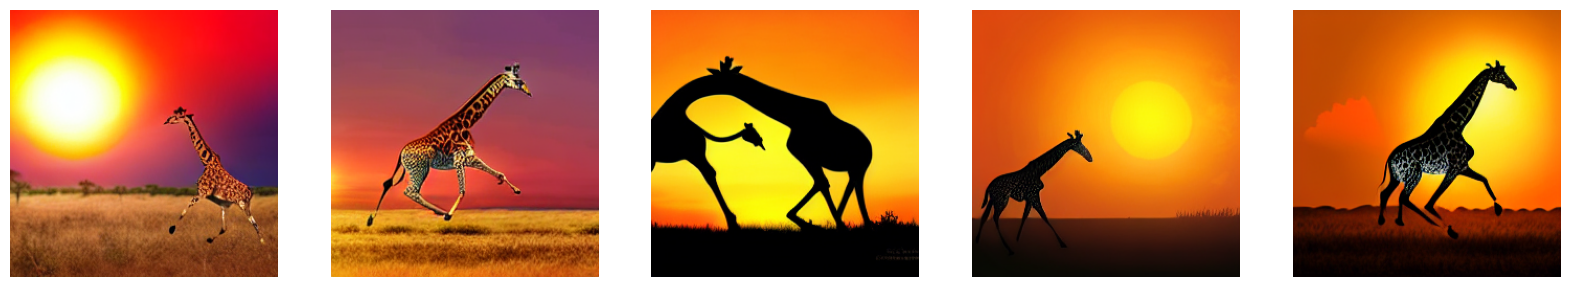

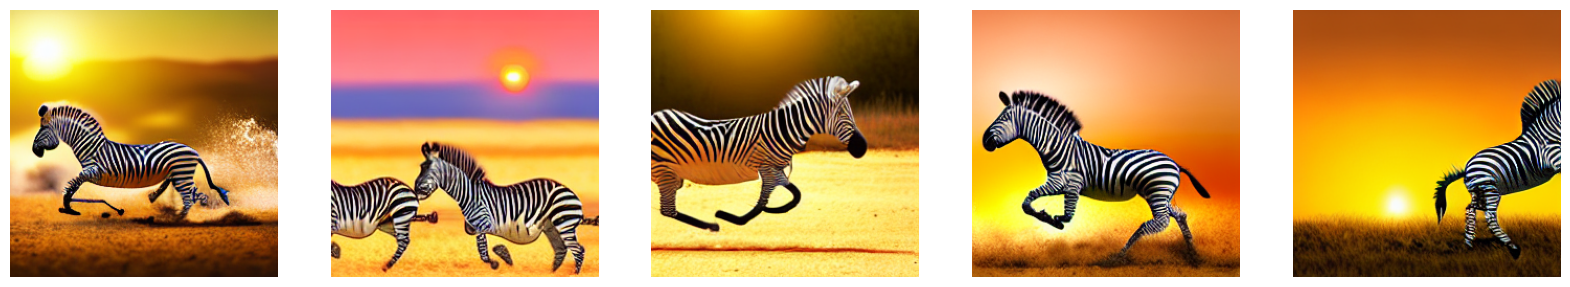

In [ ]:
show_compare("Beautiful giraffe running on sunset")

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

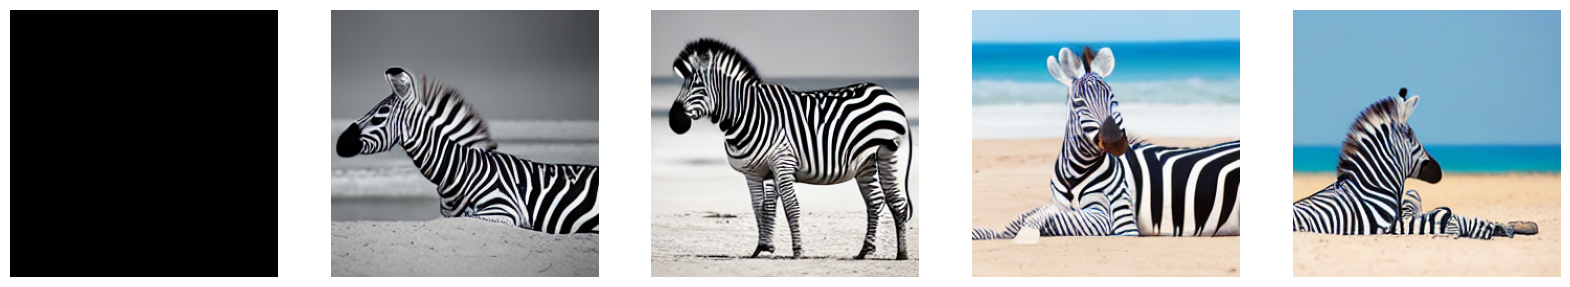

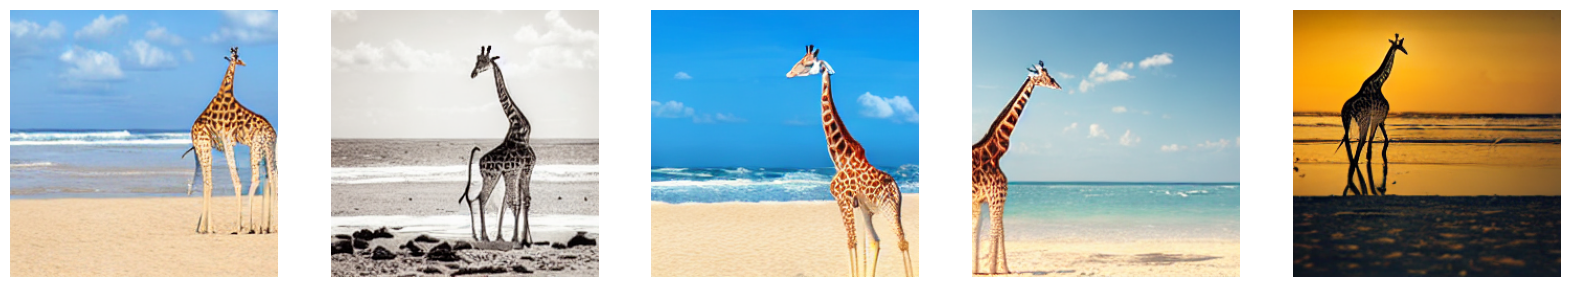

In [ ]:
show_compare("zebra chilling on the beach")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

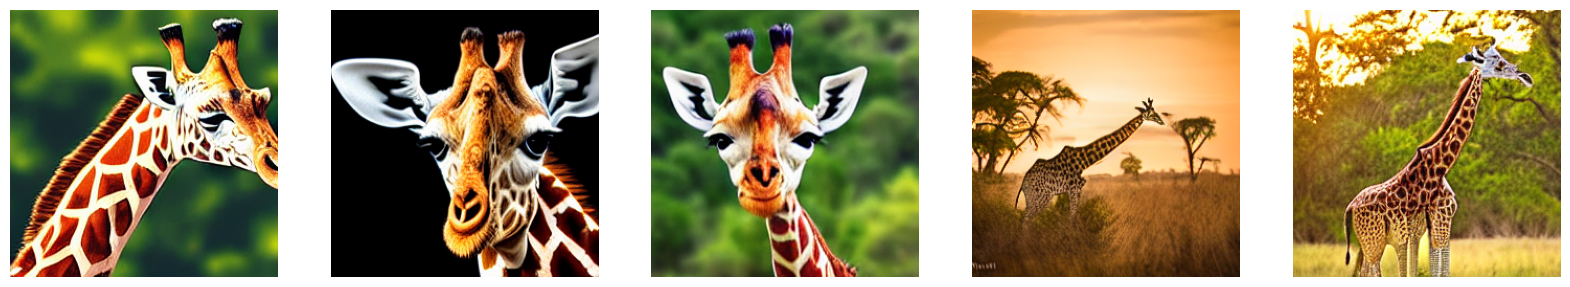

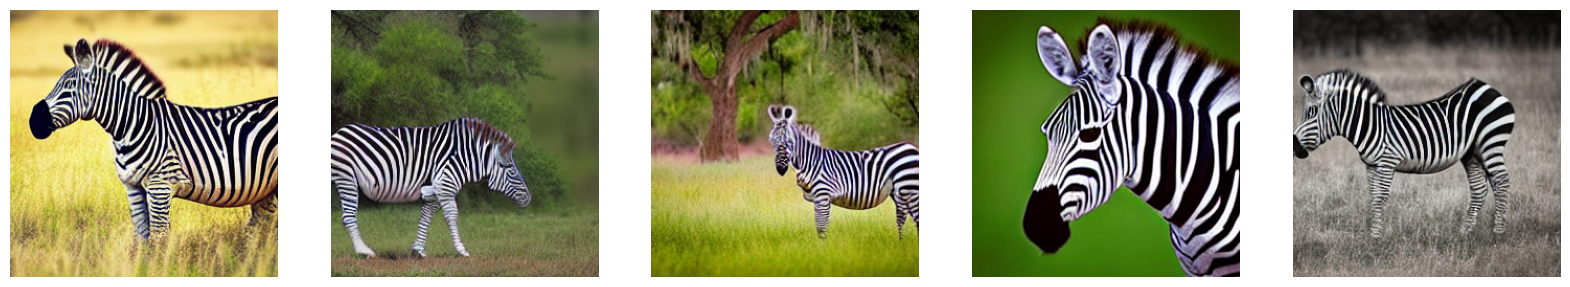

In [ ]:
show_compare("giraffe in savannah")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

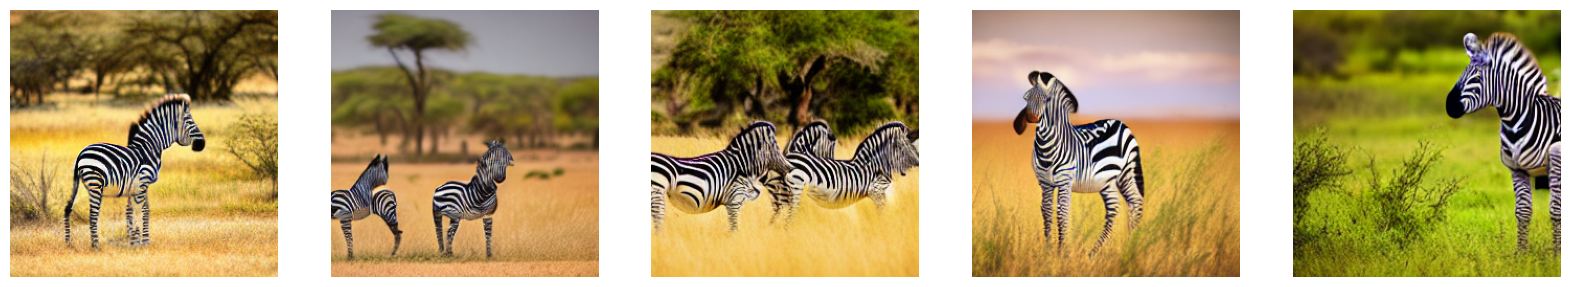

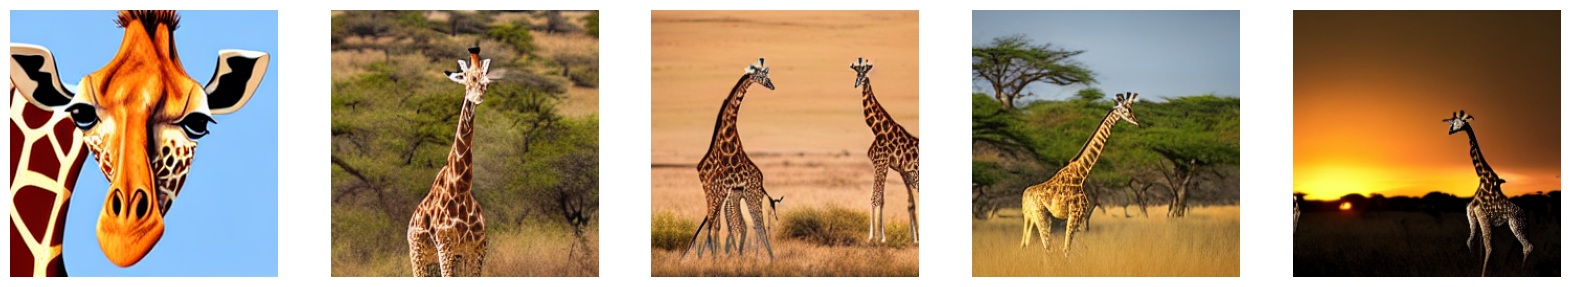

In [ ]:
show_compare("zebra in savannah")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

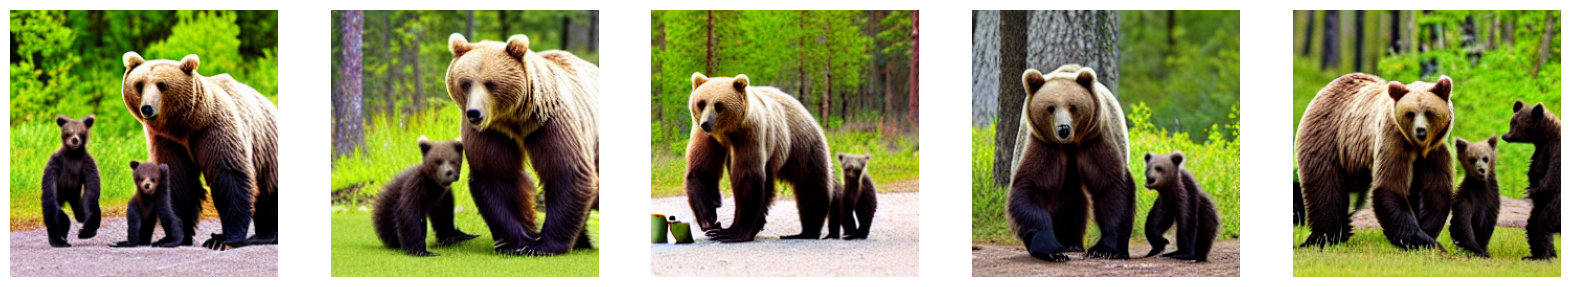

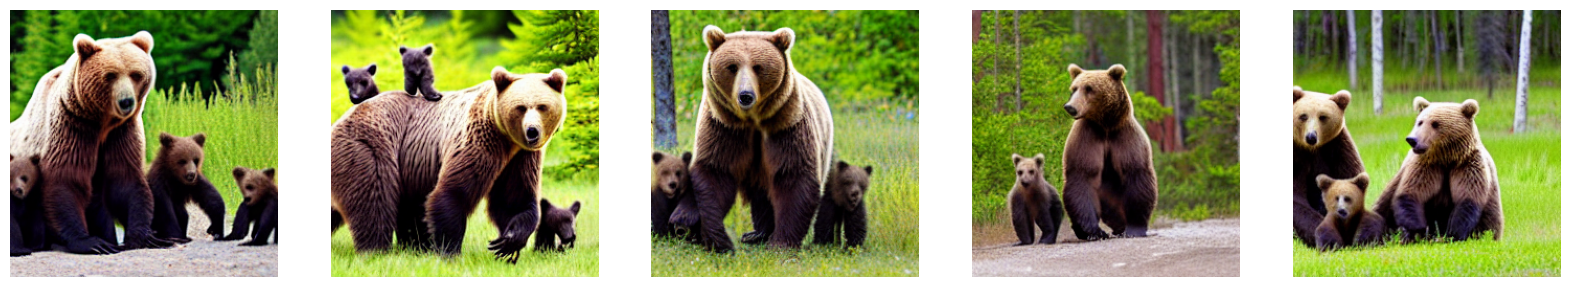

In [ ]:
show_compare("a bear mother and her cubs in forest")

As we see, it's starting to do it correctly, but there is definetely some room for improvement.


# Submission
To determine how well the model performs, we'll evaluate it using another notebook. For this reason, you need to upload the copy of trained pipeline to Hugging Face.

1. Register the team at [Hugging Face](https://huggingface.co) or login if you have account alrady.
2. Obtain an access token with write rights from [Hugging Face Tokens](https://huggingface.co/settings/tokens).
3. In the code below, replace account name with the one you registered and model name with any name you find approprate.
4. Enter the access token.

Use the [evaluation notebook](https://colab.research.google.com/drive/12eRsJK5AUDoKZOFQo60pzMLdmSJZhl3E) to check the results.



In [ ]:
from google.colab import userdata

new_pipeline = DiffusionPipeline.from_pretrained(
    base_model_name,
    vae=pipe.vae,
    unet=pipe.unet,
)
new_pipeline.push_to_hub("teamletovo/zebrified_sd", token=userdata.get('hf_write'))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]